In [1]:
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd

## Web Scraping

<img src="sample.jpg" width="1000">

In [2]:
def get_rating(link):
    page = urlopen(link)
    soup = BeautifulSoup(page, 'html.parser')
    score = soup.find("em", class_='cnt')
    return score.contents[0]

In [3]:
def get_chapter(link):
    page = urlopen(link)
    soup = BeautifulSoup(page, 'html.parser')
    chapter = soup.find("span", class_='tx')
    chapter = chapter.contents[0]
    return int(chapter.replace("#",''))

In [4]:
def get_creator(link):
    creators = []
    page = urlopen(link)
    soup = BeautifulSoup(page, 'html.parser')
    info = soup.find_all(class_='author _btnAuthorInfo NPI=a:creator,g:en_en')
    if len(info) == 0:
        info = soup.find_all('span',class_='authors_name')
    for i in info:
        creators.append(i.contents[0])
    return len(creators) # Since the names of the creator doesn't give us much information
                         # we can count how many creators there are

In [7]:
# Last Update: September 5, 2019

quote_page = 'https://www.webtoons.com/en/dailySchedule'

# query the website and return the html to the variable ‘page’
page = urlopen(quote_page)
soup = BeautifulSoup(page, 'html.parser')

# create csv
webtoon_data = csv.writer(open('webtoons.csv', 'w'))
webtoon_data.writerow(['Name', 'Creator','Heart', 'Score', 'Genre', 'Status', 'Episode'])

everyday = np.array(["MONDAY","TUESDAY","WEDNESDAY","THURSDAY","FRIDAY","SATURDAY","SUNDAY","COMPLETED"])
for i in range(len(everyday)):
    if everyday[i] == "COMPLETED":
        update_find = "daily_lst comp"
    else: 
        update_find = "daily_section _list_" + everyday[i]
    d_day = soup.find(class_= update_find)
    name = d_day.find_all('p', class_ = 'subj')
    likes = d_day.find_all('em')
    score = d_day.find_all()
    genre = d_day.find_all('p', class_ = 'genre')
    webtoon_link = []
    for link in d_day.find_all('a'):
        if link.get('href') == "#":
            continue
        else:
            webtoon_link.append(link.get('href'))
    for n,l,g,s in zip(name, likes, genre, range(len(webtoon_link))):
        N = n.contents[0]
        L = l.contents[0]
        G = g.contents[0]
        scores = get_rating(webtoon_link[s])
        chapters = get_chapter(webtoon_link[s])
        authors = get_creator(webtoon_link[s])
        webtoon_data.writerow([N,authors,L,scores,G,everyday[i],chapters])  

## Webtoon Dataset

In [8]:
df = pd.read_csv('webtoons.csv')
len(df)

362

In [9]:
df.head(10)

,Name,Creator,Heart,Score,Genre,Status,Episode
0,SubZero,1,3.1M,9.82,Romance,MONDAY,35
1,Cursed Princess Club,1,1.9M,9.76,Comedy,MONDAY,32
2,Edith,1,2M,9.76,Romance,MONDAY,32
3,Sweet Home,2,6.4M,9.84,Thriller,MONDAY,89
4,My Giant Nerd Boyfriend,1,22.4M,9.73,Slice of life,MONDAY,344
5,Ghost Wife,1,4.8M,9.68,Romance,MONDAY,92
6,Tower of God,1,14.1M,9.83,Fantasy,MONDAY,442
7,Choco Latte,1,"343,065",9.70,Romance,MONDAY,11
8,Code Adam,1,"375,861",9.79,Action,MONDAY,13
9,Room of Swords,1,2M,9.78,Sci-fi,MONDAY,82


## Data Cleaning

Task 1: Delete repeated webtoons since some of them update more than once a week

In [11]:
df.loc[df['Name'] == "Yumi's Cells"]

,Name,Creator,Heart,Score,Genre,Status,Episode
67,Yumi's Cells,1,7.9M,9.73,Romance,WEDNESDAY,405
158,Yumi's Cells,1,7.9M,9.73,Romance,SATURDAY,405


In [12]:
df.drop_duplicates(subset = "Name", inplace = True)
len(df) # dropped 45 duplicates

317

Task 2: Change the Heart column from a string to a float

In [14]:
def value_to_float(x):
    if "M" in x:
        return float(x.replace('M',''))*1000000
    if "," in x:
        return float(x.replace(',',''))
    
# Apply value_to_float function to the Heart column
df['Heart'] = df['Heart'].map(value_to_float)

Task 3: Convert weekday as string to respected integers and completed webtoon to 0

In [15]:
import calendar

def str_to_int(x):
    if x == "COMPLETED":
        return 0
    x = str.title(x)
    days = dict(zip(calendar.day_name, range(7)))
    return days[x]+1

# Apply str_to_int function to the Status column 
df['Status'] = df['Status'].map(str_to_int)

In [16]:
df.head()

,Name,Creator,Heart,Score,Genre,Status,Episode
0,SubZero,1,3100000.0,9.82,Romance,1,35
1,Cursed Princess Club,1,1900000.0,9.76,Comedy,1,32
2,Edith,1,2000000.0,9.76,Romance,1,32
3,Sweet Home,2,6400000.0,9.84,Thriller,1,89
4,My Giant Nerd Boyfriend,1,22400000.0,9.73,Slice of life,1,344


In [17]:
df.describe()

,Creator,Heart,Score,Status,Episode
count,317.000000,3.170000e+02,317.000000,317.000000,317.000000
mean,1.201893,2.018442e+06,9.350631,1.848580,112.283912
std,0.402047,3.492370e+06,0.654262,2.337593,124.116733
min,1.000000,5.527000e+03,5.560000,0.000000,3.000000
25%,1.000000,1.934770e+05,9.220000,0.000000,28.000000
50%,1.000000,5.405010e+05,9.550000,0.000000,69.000000
75%,1.000000,2.000000e+06,9.730000,3.000000,144.000000
max,2.000000,2.240000e+07,9.930000,7.000000,714.000000


In [318]:
# Save the changes
# df.to_csv('webtoons_data.csv', index = False) 
# df = pd.read_csv('webtoons_data.csv')

## Basic Analysis

What are the webtoons updated on Monday? How many of them have a score below the average score of all webtoons? What are they?

In [18]:
# To query webtoons updated on Monday
monday = df[df.Status == 1]
monday.head()

,Name,Creator,Heart,Score,Genre,Status,Episode
0,SubZero,1,3100000.0,9.82,Romance,1,35
1,Cursed Princess Club,1,1900000.0,9.76,Comedy,1,32
2,Edith,1,2000000.0,9.76,Romance,1,32
3,Sweet Home,2,6400000.0,9.84,Thriller,1,89
4,My Giant Nerd Boyfriend,1,22400000.0,9.73,Slice of life,1,344


In [19]:
avg_score = df['Score'].mean()
avg_score 

9.350630914826498

In [20]:
# To query those with a score lower than average
below_avg = monday[monday['Score'] < avg_score]
below_avg

,Name,Creator,Heart,Score,Genre,Status,Episode
21,Messenger,2,428270.0,9.17,Fantasy,1,60


We can also sort the table by Heart

In [21]:
sort_by_heart = df.sort_values('Heart', ascending = False)
sort_by_heart[:10] # Top ten webtoons with the most Hearts

,Name,Creator,Heart,Score,Genre,Status,Episode
4,My Giant Nerd Boyfriend,1,22400000.0,9.73,Slice of life,1,344
62,Bluechair,1,21000000.0,9.73,Comedy,3,714
87,unOrdinary,1,19000000.0,9.83,Fantasy,4,159
181,Lookism,1,16800000.0,9.82,Drama,7,246
31,Winter Moon,2,15700000.0,9.45,Fantasy,2,291
112,I Love Yoo,1,14600000.0,9.83,Romance,5,99
6,Tower of God,1,14100000.0,9.83,Fantasy,1,442
30,Boyfriend of the Dead,1,14100000.0,9.78,Comedy,2,212
144,Siren's Lament,1,12800000.0,9.75,Romance,6,164
27,Let's Play,1,11900000.0,9.66,Romance,2,82


In [22]:
sort_by_heart[-10:] # Last 10 webtoons with the least amount of Hearts

,Name,Creator,Heart,Score,Genre,Status,Episode
334,The Purple Heart,2,34984.0,9.09,Superhero,0,26
344,War Cry,1,31367.0,7.19,Superhero,0,26
226,The Brooklynite,2,24389.0,9.04,Superhero,0,26
300,Just Ask Yuli,1,21391.0,7.57,Slice of life,0,25
142,Acursian,2,19110.0,7.33,Fantasy,5,9
143,FINALITY,2,15570.0,8.33,Thriller,5,8
356,City of Walls,2,14226.0,7.43,Action,0,59
269,Epic V,2,13836.0,5.67,Comedy,0,27
81,STARCROSS,1,11277.0,7.57,Superhero,3,24
230,Cyko-KO,1,5527.0,7.56,Comedy,0,26


What are the webtoon with less than 100k hearts? Which genre are more likely to get less than 100k of hearts?

In [23]:
low_heart = sort_by_heart[sort_by_heart['Heart'] < 100000]
low_heart.head()

,Name,Creator,Heart,Score,Genre,Status,Episode
332,Cyberbunk,2,98244.0,8.56,Sci-fi,0,194
139,Brothers Bond,2,98112.0,9.25,Action,5,41
212,SHADOW,2,97988.0,9.41,Fantasy,0,12
315,Tickle Town,2,96028.0,6.60,Comedy,0,180
134,Thornstone,1,94238.0,9.10,Fantasy,5,21


In [24]:
genres = df['Genre'].unique() # genres of webtoon
count_g = df['Genre'].nunique() # total number of genres
print("There are " + str(count_g) + ' genres of webtoons:')
print(genres)

There are 12 genres of webtoons:
['Romance' 'Comedy' 'Thriller' 'Slice of life' 'Fantasy' 'Action' 'Sci-fi'
 'Drama' 'Sports' 'Superhero' 'Informative' 'Horror']


In [25]:
heart_genre = low_heart['Genre'].value_counts()
heart_genre

Fantasy          10
Comedy            7
Superhero         6
Drama             5
Action            5
Slice of life     5
Sci-fi            4
Thriller          3
Romance           1
Name: Genre, dtype: int64

The genre Fantasy is the most likely to get less than 100k hearts. 

## Visualizations

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

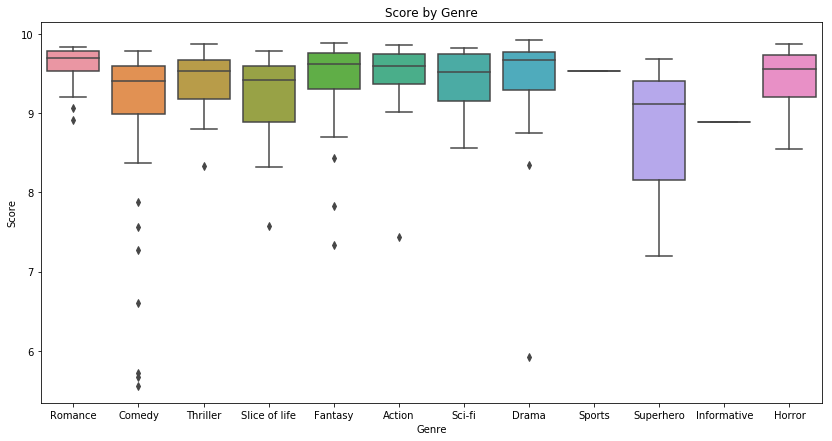

In [45]:
plt.subplots(figsize = (14,7))
plt.title('Score by Genre')
sns.boxplot(x = "Genre", y = "Score",data = df)
plt.show()

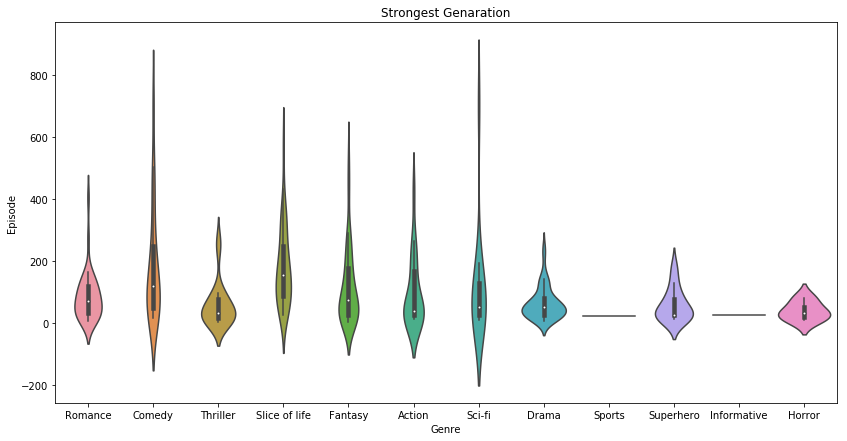

In [54]:
plt.subplots(figsize = (14,7))
plt.title('Strongest Genaration')
sns.violinplot(x = "Genre", y = "Episode",data = df)
plt.show()